## Libraries

In [1]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

## Hyperparameters

In [35]:
# Hyperparameters
batch_size = 64
learning_rate = 0.0001
num_epochs = 100
embedding_dim = 300
latent_dim = 100
num_classes = 10
noise_multiplier = 3
img_shape = (1, 28, 28)
steps_gen_per_disc = 2

## Seed

In [36]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Dataloader

In [37]:
# GPU availability
cuda = True if torch.cuda.is_available() else False

transform = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)

## Generator

In [38]:
class Generator(nn.Module):
    def __init__(self, latent_dim, embedding_dim, num_classes=10, img_shape=(1, 28, 28)):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + embedding_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.SELU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.SELU(True),

            nn.ConvTranspose2d(512, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.SELU(True),

            nn.ConvTranspose2d(128, 64, 2, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.SELU(True),

            nn.ConvTranspose2d(64, 32, 2, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.SELU(True),

            nn.ConvTranspose2d(32, 1, 4, 1, 1, bias=False),
            # self.PrintShape(),
            nn.Sigmoid(),
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and noise to produce input
        labels = labels.to(torch.long)
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        gen_input = gen_input.view(gen_input.size(0), gen_input.size(1), 1, 1)
        img = self.model(gen_input)
        return img

    # This layer might be used for debugging
    class PrintShape(nn.Module):
        def forward(self, x):
            print(x.shape)
            return x

## Discriminator

In [39]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10, img_shape=(1, 28, 28), latent_dim=100):
        super(Discriminator, self).__init__()

        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Conv2d(img_shape[0], 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.validity_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 1),
            nn.Sigmoid(),
        )

        self.label_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(True),

            nn.Linear(512, num_classes),
            nn.Softmax(dim=1),
        )

    def forward(self, img):
        features = self.model(img)
        validity = self.validity_layer(features)
        label = self.label_layer(features)

        return validity.view(-1, 1).squeeze(1), label.view(-1, label.size(1))

    class PrintShape(nn.Module):
        def forward(self, x):
            print(x.shape)
            return x

## Losses

In [40]:
# Loss
adversarial_loss = nn.BCELoss()
auxiliary_loss = nn.CrossEntropyLoss()

## Create Instances

In [41]:
generator = Generator(latent_dim=latent_dim, embedding_dim=embedding_dim)
discriminator = Discriminator()

In [42]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

In [43]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

## Training

In [44]:
if os.path.exists("models"):
    shutil.rmtree("models")
os.makedirs("models", exist_ok=True)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Step: 500


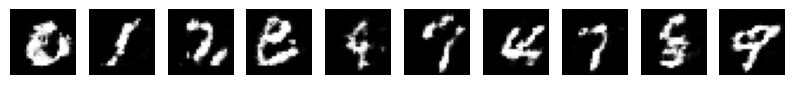

Epoch 1 | Generator loss: 2.369476415709392, Discriminator loss: 2.2382202119207077
Disc Accuracy validity: 0.5488666666666666
Disc Accuracy class: 0.9519916666666667
Epoch: 2, Step: 1000


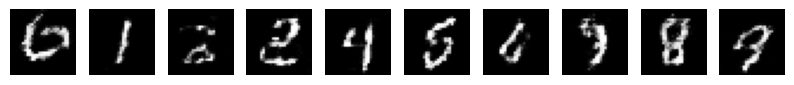

Epoch: 2, Step: 1500


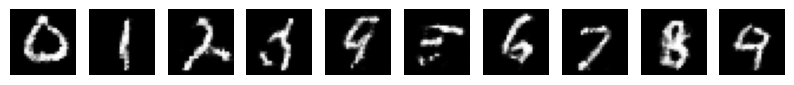

Epoch 2 | Generator loss: 2.3024110983429686, Discriminator loss: 2.2091788854807426
Disc Accuracy validity: 0.557725
Disc Accuracy class: 0.9856166666666667
Epoch: 3, Step: 2000


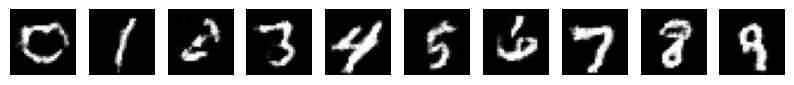

Epoch: 3, Step: 2500


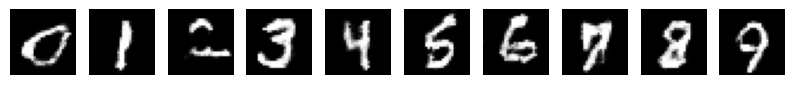

Epoch 3 | Generator loss: 2.2944863909258433, Discriminator loss: 2.189387375484906
Disc Accuracy validity: 0.6124666666666667
Disc Accuracy class: 0.9890833333333333
Epoch: 4, Step: 3000


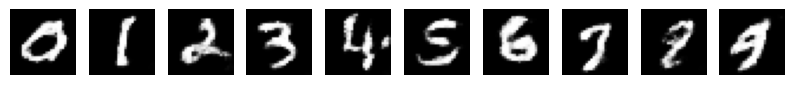

Epoch: 4, Step: 3500


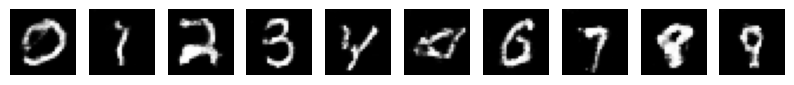

Epoch 4 | Generator loss: 2.311875194438231, Discriminator loss: 2.1702650673290305
Disc Accuracy validity: 0.67405
Disc Accuracy class: 0.9870166666666667
Epoch: 5, Step: 4000


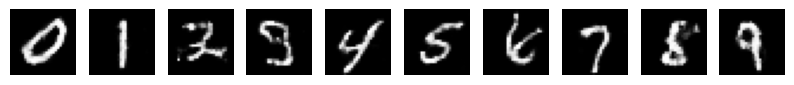

Epoch: 5, Step: 4500


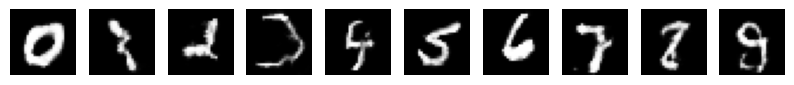

Epoch 5 | Generator loss: 2.335724083955354, Discriminator loss: 2.152654732773299
Disc Accuracy validity: 0.704225
Disc Accuracy class: 0.9912916666666667
Epoch: 6, Step: 5000


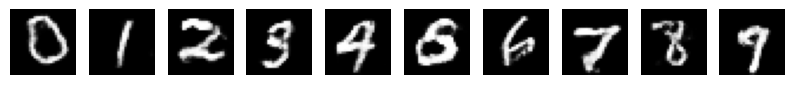

Epoch: 6, Step: 5500


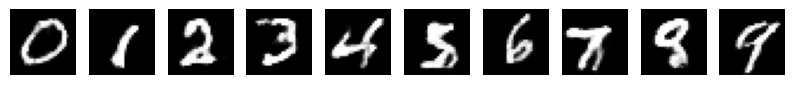

Epoch 6 | Generator loss: 2.3645067564883635, Discriminator loss: 2.1362693811784674
Disc Accuracy validity: 0.7365666666666667
Disc Accuracy class: 0.9880416666666667
Epoch: 7, Step: 6000


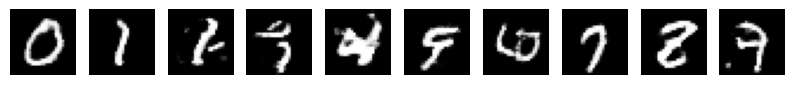

Epoch: 7, Step: 6500


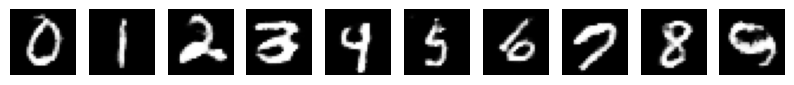

Epoch 7 | Generator loss: 2.3962527324323277, Discriminator loss: 2.1199556019768786
Disc Accuracy validity: 0.7655416666666667
Disc Accuracy class: 0.9877416666666666


KeyboardInterrupt: ignored

In [45]:
# Training loop
device = "cuda" if cuda else "cpu"

total_steps = 0
disc_loss = []
gen_loss = []
disc_validity_acc = []
disc_class_acc = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    correct_preds_validity = 0
    correct_preds_class = 0
    total_preds = 0
    for i, (imgs, labels) in enumerate(dataloader):
        imgs = imgs.to(device)
        labels = labels.to(device).squeeze()

        valid = torch.full((imgs.size(0), 1), 1.0, device=imgs.device).squeeze()
        fake = torch.full((imgs.size(0), 1), 0.0, device=imgs.device).squeeze()

        for _ in range(steps_gen_per_disc):
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Generate a batch of images
            noise = noise_multiplier * torch.randn(imgs.size(0), latent_dim).to(imgs.device)
            gen_labels = torch.randint(0, num_classes, (imgs.size(0),)).to(imgs.device).squeeze()
            generated_imgs = generator(noise, gen_labels)

            # Loss measures generator's ability to fool the discriminator
            validity, classes_fake = discriminator(generated_imgs)
            g_loss = adversarial_loss(validity, valid)
            g_loss += auxiliary_loss(classes_fake, gen_labels)

            g_loss.backward()
            optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Generate a batch of images
        noise = noise_multiplier * torch.randn(imgs.size(0), latent_dim).to(imgs.device)
        gen_labels = torch.randint(0, num_classes, (imgs.size(0),)).to(imgs.device).squeeze()
        generated_imgs = generator(noise, gen_labels)

        # Loss for real images
        validity_real, classes_real = discriminator(imgs)
        correct_preds_validity += (validity_real > 0.5).sum().item()
        correct_preds_class += (classes_real.argmax(dim=1) == labels).sum().item()
        total_preds += validity_real.size(0)
        d_real_loss = adversarial_loss(validity_real, valid)
        d_real_loss_class = auxiliary_loss(classes_real, labels)

        # Loss for fake images
        validity_fake, classes_fake = discriminator(generated_imgs.detach())
        correct_preds_validity += (validity_fake < 0.5).sum().item()
        correct_preds_class += (classes_fake.argmax(dim=1) == gen_labels).sum().item()
        total_preds += validity.size(0)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss)/2 + d_real_loss_class

        d_loss.backward()
        optimizer_D.step()
        # scheduler_D.step()

        total_steps += 1

        if total_steps % 500 == 0:
            # Generate images
            noise = noise_multiplier * torch.randn(num_classes, latent_dim).to(imgs.device)
            gen_labels = torch.arange(0, num_classes).to(imgs.device)
            generated_imgs = generator(noise, gen_labels)

            # Display images
            plt.figure(figsize=(10,10))
            print(f"Epoch: {epoch+1}, Step: {total_steps}")
            for k in range(10):
                plt.subplot(1, 10, k+1)
                plt.imshow(generated_imgs[k].cpu().detach().squeeze().numpy(), cmap='gray')
                plt.axis('off')
            plt.show()

        disc_loss.append(d_loss.item())
        gen_loss.append(g_loss.item())

    print(f"Epoch {epoch+1} | Generator loss: {sum(gen_loss)/len(gen_loss)}, Discriminator loss: {sum(disc_loss)/len(disc_loss)}")
    print(f"Disc Accuracy validity: {correct_preds_validity/total_preds}")
    print(f"Disc Accuracy class: {correct_preds_class/total_preds}")
    disc_validity_acc.append(correct_preds_validity/total_preds)
    disc_class_acc.append(correct_preds_class/total_preds)

    os.makedirs(f"models/epoch_{epoch+1}", exist_ok=True)
    torch.save(generator.state_dict(), f'models/epoch_{epoch+1}/generator.pt')
    torch.save(discriminator.state_dict(), f'models/epoch_{epoch+1}/discriminator.pt')


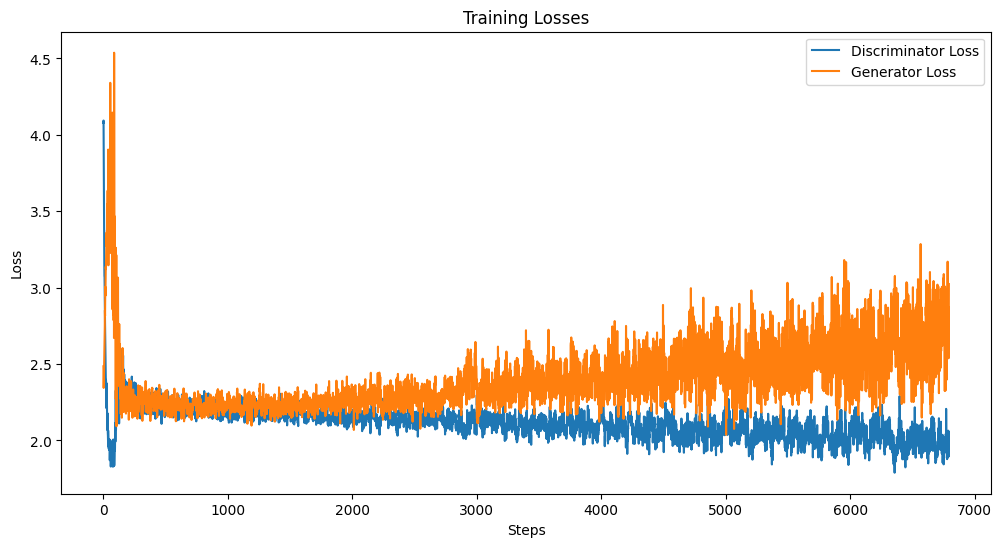

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(disc_loss, label="Discriminator Loss")
plt.plot(gen_loss, label="Generator Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()

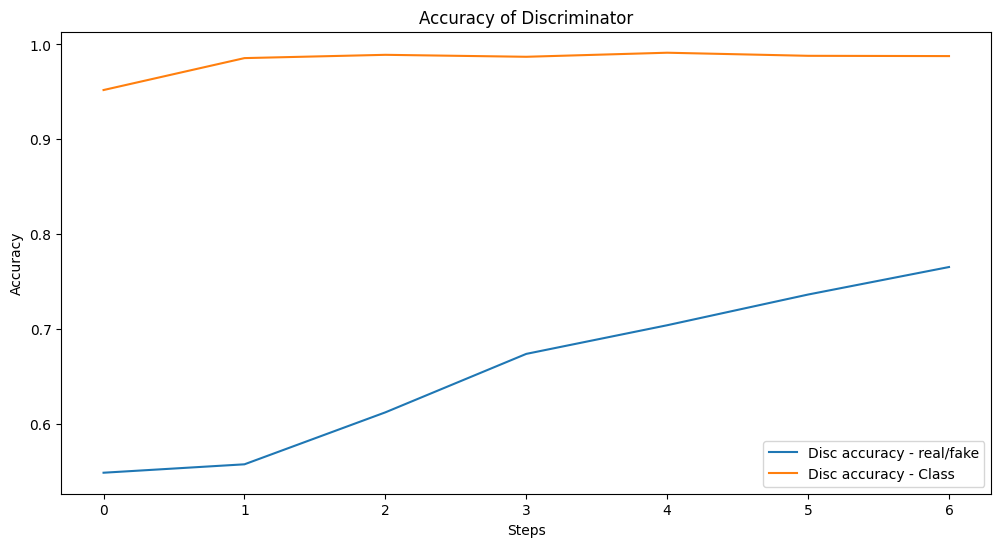

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(disc_validity_acc, label="Disc accuracy - real/fake")
plt.plot(disc_class_acc, label="Disc accuracy - Class")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy of Discriminator")
plt.show()

## Generated Images

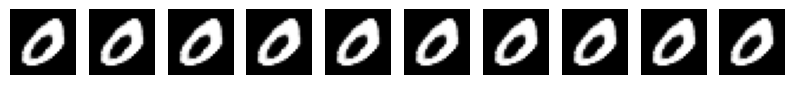

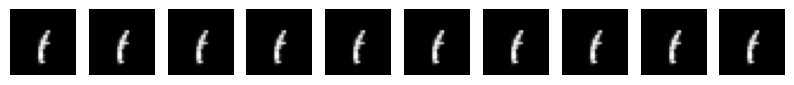

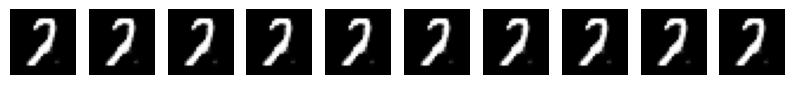

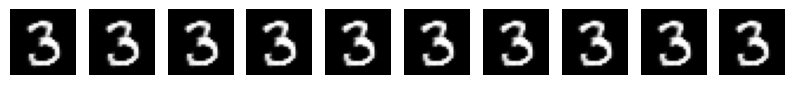

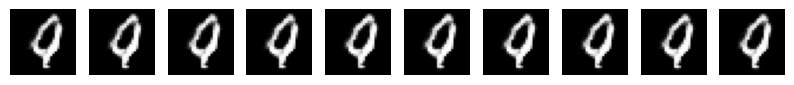

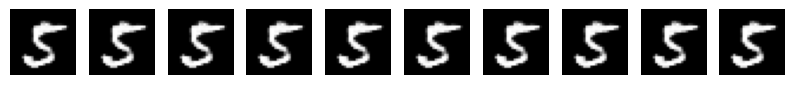

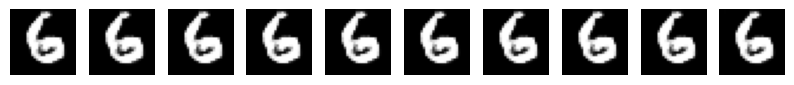

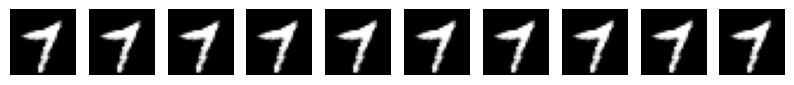

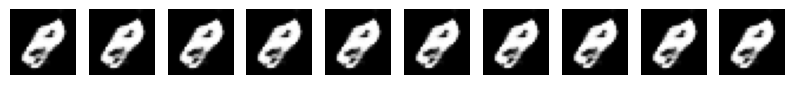

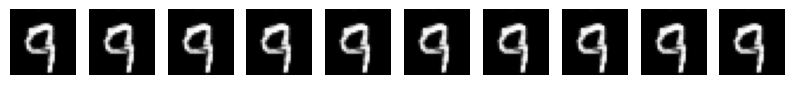

In [72]:
generator.load_state_dict(torch.load("models/epoch_7/generator.pt"))
for i in range(num_classes):
    noise = noise_multiplier * torch.randn(10, latent_dim).to(device)
    gen_labels = torch.full((10, 1), float(i)).to(device).squeeze()
    generated_imgs = generator(noise, gen_labels)

    # Display images
    plt.figure(figsize=(10,10))
    for k in range(10):
        plt.subplot(1, 10, k+1)
        plt.imshow(generated_imgs[k].cpu().detach().squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()